In [15]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*XGBoost is not compiled with CUDA support.*"
)

In [16]:
with open('routerbench/routerbench_raw.pkl', 'rb') as file:
    data_raw = pickle.load(file)

with open('routerbench/routerbench_0shot.pkl', 'rb') as file:
    data0 = pickle.load(file)

with open('routerbench/routerbench_5shot.pkl', 'rb') as file:
    data5 = pickle.load(file)

with open('routerbench/data/embedding_cache_all-MiniLM-L12-v2.pkl', 'rb') as file:
    embed_all = pickle.load(file)

# with open('routerbench/data/routerbench/input_wide__04-11-04__routerbench.pkl', 'rb') as file:
#     embed_wide = pickle.load(file)

/tmp/ipykernel_23593/724477448.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data_raw = pickle.load(file)
/tmp/ipykernel_23593/724477448.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case

In [17]:
embeddings = [i['embedding'] for i in embed_all]
np.array(embeddings).shape

(36511, 384)

In [18]:
to_exclude = []

for c in pd.unique(data5['eval_name']):
    if c.startswith("mmlu"):
        continue
    elif c.startswith('mtbench'):
        continue
    elif c.startswith('mbpp'):
        continue
    elif c.startswith('hellaswag'):
        continue
    elif c.startswith('winogrande'):
        continue
    elif c.startswith('arc-challenge'):
        continue
    elif c.startswith('grade-school-math'):
        continue
    else:
        to_exclude.append(c)

to_exclude


['Chinese_character_riddles',
 'abstract2title',
 'accounting_audit',
 'bias_detection',
 'chinese-lantern-riddles',
 'chinese-remainder-theorem',
 'chinese_ancient_masterpieces_dynasty',
 'chinese_ancient_poetry',
 'chinese_chu_ci',
 'chinese_famous_novel',
 'chinese_hard_translations',
 'chinese_homonym',
 'chinese_idioms',
 'chinese_modern_poem_identification',
 'chinese_poem',
 'chinese_shi_jing',
 'chinese_song_ci',
 'chinese_tang_poetries',
 'chinese_zodiac',
 'consensus_summary',
 'test-match']

In [19]:
llms = ['WizardLM/WizardLM-13B-V1.2', 'claude-instant-v1', 'claude-v1', 'claude-v2', 'gpt-3.5-turbo-1106',
       'gpt-4-1106-preview', 'meta/code-llama-instruct-34b-chat',
       'meta/llama-2-70b-chat', 'mistralai/mistral-7b-chat',
       'mistralai/mixtral-8x7b-chat', 'zero-one-ai/Yi-34B-Chat']

llms_short = ['WizardLM 13B', 'Claude Instant v1', 'Claude v1', 'Claude v2', 'GPT-3.5',
       'GPT-4', 'Code Llama 34b',
       'Llama 70b', 'Mistral 7b',
       'Mixtral 8x7b', 'Yi 34B']

In [20]:
from sklearn.model_selection import train_test_split


def get_nan_row_indices(arr):
    """
    Returns the indices of rows containing NaN values in a NumPy array.

    Args:
        arr (np.ndarray): The input NumPy array.

    Returns:
        np.ndarray: An array of row indices containing NaN values.
    """
    nan_mask = np.isnan(arr)
    row_has_nan = np.any(nan_mask, axis=1)
    return np.where(row_has_nan)[0]


filter_categories = 1

if filter_categories:
    mask_to_keep = ~data5['eval_name'].isin(to_exclude)
    data5 = data5[mask_to_keep].reset_index()

    embeddings_array = np.array(embeddings)
    embeddings = embeddings_array[mask_to_keep].tolist()

y_cost = np.zeros((len(embeddings), 11))
y_acc = np.zeros((len(embeddings), 11))

llm_acc_cost = ['WizardLM/WizardLM-13B-V1.2',
       'claude-instant-v1', 'claude-v1', 'claude-v2', 'gpt-3.5-turbo-1106',
       'gpt-4-1106-preview', 'meta/code-llama-instruct-34b-chat',
       'meta/llama-2-70b-chat', 'mistralai/mistral-7b-chat',
       'mistralai/mixtral-8x7b-chat', 'zero-one-ai/Yi-34B-Chat',
       'WizardLM/WizardLM-13B-V1.2|total_cost', 'claude-instant-v1|total_cost',
       'claude-v1|total_cost', 'claude-v2|total_cost',
       'gpt-3.5-turbo-1106|total_cost',
       'gpt-4-1106-preview|total_cost', 'meta/code-llama-instruct-34b-chat|total_cost', 'meta/llama-2-70b-chat|total_cost',
       'mistralai/mistral-7b-chat|total_cost', 'mistralai/mixtral-8x7b-chat|total_cost',
       'zero-one-ai/Yi-34B-Chat|total_cost']

for i in range(len(embeddings)):
    for j in range(11):
        y_cost[i, j] = data5[llm_acc_cost[j+11]][i]
        y_acc[i, j] = data5[llm_acc_cost[j]][i]

eval_data = data5['eval_name']

indices_to_delete = get_nan_row_indices(y_acc)
embeddings_clean = np.delete(embeddings, indices_to_delete, axis=0)
y_cost_clean = np.delete(y_cost, indices_to_delete, axis=0)
y_acc_clean = np.delete(y_acc, indices_to_delete, axis=0)
eval_data_clean = eval_data.drop(eval_data.index[indices_to_delete]).reset_index(drop=True)


x_train, x_test, y_acc_train, y_acc_test, y_cost_train, y_cost_test, eval_train, eval_test = train_test_split(embeddings_clean, y_acc_clean, y_cost_clean, eval_data_clean, stratify=eval_data_clean, test_size = 0.2, random_state=42)


Training NICKernel Multi-Output model...
✓ NICKernel Multi-Output Done!

Training XGBoost Multi-Output model...
✓ XGBoost Multi-Output Done!

Training Random Forest Multi-Output model...
✓ Random Forest Multi-Output Done!



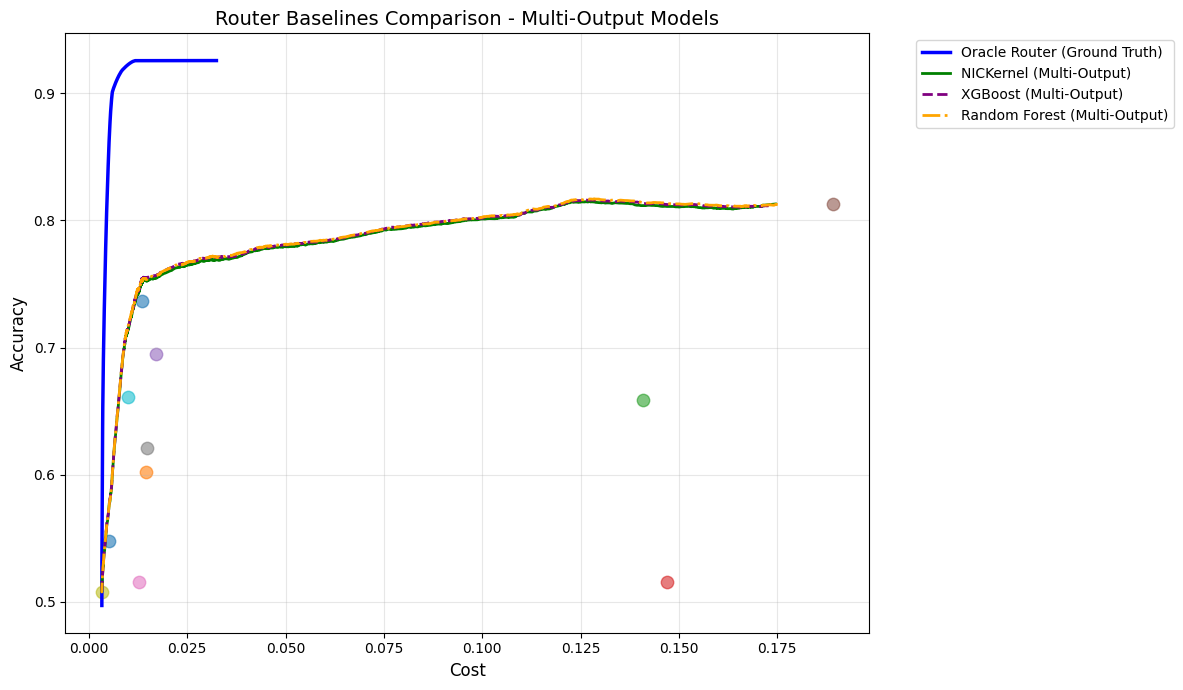


MULTI-OUTPUT BASELINE COMPARISON RESULTS
Oracle:                      Mean Acc: 0.9181, Mean Cost: 0.0104
NICKernel (Multi-Output):    Mean Acc: 0.7619, Mean Cost: 0.0524
XGBoost (Multi-Output):      Mean Acc: 0.7641, Mean Cost: 0.0528
Random Forest (Multi-Output): Mean Acc: 0.7641, Mean Cost: 0.0530

XGBoost vs NICKernel:     +0.29% accuracy difference
Random Forest vs NICKernel: +0.29% accuracy difference
Random Forest vs XGBoost:   +0.00% accuracy difference

Best Performing Model:  Random Forest with 0.7641 mean accuracy
Worst Performing Model: NICKernel with 0.7619 mean accuracy
Performance Gap: 0.0022


In [8]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from skactiveml.regressor import NICKernelRegressor

def score_auc(y_acc_test, y_cost_test, y_acc_pred, y_cost_pred, lam):
    n = y_acc_test.shape[0]
    y_cost_pred_ = y_cost_pred / np.max(y_cost_pred)
    y_cost_test_ = y_cost_test/np.max(y_cost_test)
    model_idx = ((1 - lam) * y_acc_pred - lam * y_cost_pred_).argmax(axis = 1)
    final_acc = np.zeros(n)
    final_cost = np.zeros(n)
    final_acc = y_acc_test[np.arange(n), model_idx]
    final_cost = y_cost_test_[np.arange(n), model_idx]
    return np.mean(final_acc), np.mean(final_cost)

lambdas = np.arange(0, 1.001, 0.0001)

# Oracle baseline
acc_oracle = np.zeros(len(lambdas))
cost_oracle = np.zeros(len(lambdas))
y_acc_pred_oracle = y_acc_test
y_cost_pred_oracle = y_cost_test

for i, lam in enumerate(lambdas):
    acc_oracle[i], cost_oracle[i] = score_auc(
      y_acc_test, y_cost_test, y_acc_pred_oracle, y_cost_pred_oracle, lam
    )

# NICKernelRegressor - Multi-Output
print("Training NICKernel Multi-Output model...")
nick_multi = MultiOutputRegressor(NICKernelRegressor(metric_dict={'gamma': 15.0}))
nick_multi.fit(x_train, y_acc_train)
y_acc_pred_nick_multi = nick_multi.predict(x_test)

acc_nick_multi = np.zeros(len(lambdas))
cost_nick_multi = np.zeros(len(lambdas))

for i, lam in enumerate(lambdas):
    acc_nick_multi[i], cost_nick_multi[i] = score_auc(
      y_acc_test, y_cost_test, y_acc_pred_nick_multi, y_cost_test, lam
    )
print("✓ NICKernel Multi-Output Done!\n")

# XGBoost - Multi-Output
print("Training XGBoost Multi-Output model...")
xgb_reg = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    device="cuda",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1e-3,
    reg_lambda=1.0,
    gamma=0.0,
    max_bin=256,
    random_state=42,
)

xgb_multi = MultiOutputRegressor(xgb_reg)
xgb_multi.fit(x_train, y_acc_train)
y_acc_pred_xgb = xgb_multi.predict(x_test)

acc_xgb = np.zeros(len(lambdas))
cost_xgb = np.zeros(len(lambdas))

for i, lam in enumerate(lambdas):
    acc_xgb[i], cost_xgb[i] = score_auc(
      y_acc_test, y_cost_test, y_acc_pred_xgb, y_cost_test, lam
    )
print("✓ XGBoost Multi-Output Done!\n")

# Random Forest - Multi-Output
print("Training Random Forest Multi-Output model...")
rf_reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

rf_multi = MultiOutputRegressor(rf_reg)
rf_multi.fit(x_train, y_acc_train)
y_acc_pred_rf = rf_multi.predict(x_test)

acc_rf = np.zeros(len(lambdas))
cost_rf = np.zeros(len(lambdas))

for i, lam in enumerate(lambdas):
    acc_rf[i], cost_rf[i] = score_auc(
      y_acc_test, y_cost_test, y_acc_pred_rf, y_cost_test, lam
    )
print("✓ Random Forest Multi-Output Done!\n")

# Plotting
plt.figure(figsize=(12, 7))

plt.plot(cost_oracle, acc_oracle, 'b-', linewidth=2.5, label='Oracle Router (Ground Truth)')
plt.plot(cost_nick_multi, acc_nick_multi, 'green', linestyle='-', linewidth=2,
      label='NICKernel (Multi-Output)')
plt.plot(cost_xgb, acc_xgb, 'purple', linestyle='--', linewidth=2,
      label='XGBoost (Multi-Output)')
plt.plot(cost_rf, acc_rf, 'orange', linestyle='-.', linewidth=2,
      label='Random Forest (Multi-Output)')

# Plot individual LLM points
for i, llm in enumerate(llms_short):
    avg_acc = np.mean(y_acc_test[:, i])
    avg_cost = np.mean(y_cost_test[:, i]) / np.max(y_cost_test)
    plt.scatter(avg_cost, avg_acc, s=80, alpha=0.6)

plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Router Baselines Comparison - Multi-Output Models', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "="*60)
print("MULTI-OUTPUT BASELINE COMPARISON RESULTS")
print("="*60)
print(f"Oracle:                      Mean Acc: {acc_oracle.mean():.4f}, Mean Cost: {cost_oracle.mean():.4f}")
print(f"NICKernel (Multi-Output):    Mean Acc: {acc_nick_multi.mean():.4f}, Mean Cost: {cost_nick_multi.mean():.4f}")
print(f"XGBoost (Multi-Output):      Mean Acc: {acc_xgb.mean():.4f}, Mean Cost: {cost_xgb.mean():.4f}")
print(f"Random Forest (Multi-Output): Mean Acc: {acc_rf.mean():.4f}, Mean Cost: {cost_rf.mean():.4f}")
print("="*60)

# Calculate improvements relative to NICKernel as baseline
xgb_vs_nick = ((acc_xgb.mean() - acc_nick_multi.mean()) / acc_nick_multi.mean()) * 100
rf_vs_nick = ((acc_rf.mean() - acc_nick_multi.mean()) / acc_nick_multi.mean()) * 100
rf_vs_xgb = ((acc_rf.mean() - acc_xgb.mean()) / acc_xgb.mean()) * 100

print(f"\nXGBoost vs NICKernel:     {xgb_vs_nick:+.2f}% accuracy difference")
print(f"Random Forest vs NICKernel: {rf_vs_nick:+.2f}% accuracy difference")
print(f"Random Forest vs XGBoost:   {rf_vs_xgb:+.2f}% accuracy difference")

# Find best performer
best_models = {
  'NICKernel': acc_nick_multi.mean(),
  'XGBoost': acc_xgb.mean(),
  'Random Forest': acc_rf.mean()
}
best_model = max(best_models, key=best_models.get)
worst_model = min(best_models, key=best_models.get)

print(f"\nBest Performing Model:  {best_model} with {best_models[best_model]:.4f} mean accuracy")
print(f"Worst Performing Model: {worst_model} with {best_models[worst_model]:.4f} mean accuracy")
print(f"Performance Gap: {(best_models[best_model] - best_models[worst_model]):.4f}")

In [ ]:
from skactiveml.regressor import NICKernelRegressor
from skactiveml.pool import GreedySamplingTarget
import os
# from datetime import datetime

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

llm_name_map = {}
for i in range(len(llms_short)):
    llm_name_map[llms[i]] = llms_short[i]

def active_learn_and_save_regressors(llms_to_train, x_train, y_train, directory, initial_batch_size=50, batch_size=50, gamma=15.0, save_interval=1, random_state=42):

    os.makedirs(directory, exist_ok=True)

    qs = GreedySamplingTarget(random_state=random_state)

    n_iterations = 270

    for llm in llms_to_train:
        # start_time = datetime.now()

        regressor = NICKernelRegressor(metric_dict={'gamma': gamma})
        idx = llms.index(llm)
        y_true = y_train[:, idx]
        y_labeled = np.full_like(y_true, np.nan)

        y_labeled[:initial_batch_size] = y_true[:initial_batch_size]
        regressor.fit(x_train, y_labeled)
        llm_short_name = llm_name_map[llm]
        check_point_path = f"{directory}/{llm_short_name}_{initial_batch_size}.pkl"
        with open(check_point_path, 'wb') as file:
            pickle.dump(regressor, file)

        for iter in range(n_iterations):
            # iter_start_time = datetime.now()

            query_idx, _ = qs.query(X=x_train, y=y_labeled, reg=regressor, fit_reg=True, return_utilities=True, batch_size=batch_size)
            y_labeled[query_idx] = y_true[query_idx]
            regressor.fit(x_train, y_labeled)

            if iter % save_interval == 0:
                labeled = initial_batch_size + ((iter+1) * batch_size)
                checkpoint_path = f"{directory}/{llm_short_name}_{labeled}.pkl"
                with open(checkpoint_path, 'wb') as file:
                    pickle.dump(regressor, file)

In [ ]:
active_learn_and_save_regressors(
    llms_to_train=['zero-one-ai/Yi-34B-Chat'],
    x_train=x_train,
    y_train=y_acc_train,
    directory='my_checkpoints_yi_2',
    initial_batch_size=50,
    batch_size=50,
    gamma=15.0,
    save_interval=1,
    random_state=42
)

In [ ]:
yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')

y_acc_pred_xgb_baseline = xgb_multi.predict(x_test)
acc_xgb_baseline = np.zeros(len(lambdas))
cost_xgb_baseline = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_xgb_baseline[idx], cost_xgb_baseline[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_xgb_baseline, y_cost_test, lam
    )


y_acc_pred_leave_out = np.zeros(y_acc_test.shape)
for idx in range(11):
    if idx != yi_idx:
        y_acc_pred_leave_out[:, idx] = y_acc_pred_xgb_baseline[:, idx]

acc_leave_out = np.zeros(len(lambdas))
cost_leave_out = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_leave_out[idx], cost_leave_out[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_leave_out, y_cost_test, lam
    )


sample_sizes = [1100, 1300, 1500, 1700, 1900, 2100]
qbc_learning_curves = {}
qbc_directory = 'qbc_checkpoints_yi'

for n_samples in sample_sizes:
    checkpoint_path = f"{qbc_directory}/Yi_34B_{n_samples}.pkl"

    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)

        if isinstance(checkpoint, dict):
            committee = checkpoint['committee']
        else:
            committee = checkpoint

        predictions = np.zeros((len(x_test), len(committee)))
        for i, model in enumerate(committee):
            predictions[:, i] = model.predict(x_test)
        ensemble_pred = np.mean(predictions, axis=1)

        y_acc_pred_qbc = y_acc_pred_leave_out.copy()
        y_acc_pred_qbc[:, yi_idx] = ensemble_pred

        acc_curve = np.zeros(len(lambdas))
        cost_curve = np.zeros(len(lambdas))

        for idx, lam in enumerate(lambdas):
            acc_curve[idx], cost_curve[idx] = score_auc(
                y_acc_test, y_cost_test, y_acc_pred_qbc, y_cost_test, lam
            )

        qbc_learning_curves[n_samples] = (acc_curve, cost_curve)

        y_test_yi = y_acc_test[:, yi_idx]
        mse = np.mean((y_test_yi - ensemble_pred) ** 2)

#plot
plt.figure(figsize=(16, 6))

plt.ylim(0.65, 0.85)
plt.xlim(-0.01, 0.25)

plt.plot(cost_xgb_baseline, acc_xgb_baseline, '-', color='green',
         label='XGBoost Baseline (all trained)', linewidth=2)
plt.plot(cost_leave_out, acc_leave_out, '-', color='red',
         label='Leave Yi Out', linewidth=2)

colors_samples = ['b', 'c', 'm', 'y', 'k', 'orange']

for i, n_samples in enumerate(sample_sizes):
    if n_samples in qbc_learning_curves:
        acc_curve, cost_curve = qbc_learning_curves[n_samples]
        plt.plot(cost_curve, acc_curve, '--',
                color=colors_samples[i],
                label=f'QBC {n_samples} samples',
                linewidth=1.5)

markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p']
colors_llms = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'purple', 'gray', 'red']

for idx, llm in enumerate(llms):
    avg_acc = np.mean(y_acc_test[:, idx])
    avg_cost = np.mean(y_cost_test[:, idx]) / np.max(y_cost_test)
    plt.scatter(avg_cost, avg_acc, marker=markers[idx],
                color=colors_llms[idx], s=80, alpha=0.7, label=llms_short[idx])

# Labels and formatting
plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('QBC Active Learning Performance vs XGBoost Baseline', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"XGBoost Baseline (all data): {acc_xgb_baseline.mean():.4f}")
print(f"Leave Yi Out: {acc_leave_out.mean():.4f}")
if qbc_learning_curves:
    best_acc = max([curves[0].mean() for curves in qbc_learning_curves.values()])
    best_samples = [n for n, curves in qbc_learning_curves.items() if curves[0].mean() == best_acc][0]
    print(f"QBC Best ({best_samples} samples): {best_acc:.4f}")

    # Compare to baseline
    improvement = ((best_acc - acc_leave_out.mean()) / (acc_xgb_baseline.mean() - acc_leave_out.mean())) * 100
    print(f"QBC recovers {improvement:.1f}% of the performance gap")
print("="*60)

In [14]:
from skactiveml.regressor import SklearnRegressor
from skactiveml.pool import QueryByCommittee
from xgboost import XGBRegressor

def QBC_active_learning_and_save_regressors(x_train, y_train, directory, initial_batch_size=50, batch_size=50, save_interval=1, random_state=42, n_committee=7, n_iterations=150):
    os.makedirs(directory, exist_ok=True)

    yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')
    y_true = y_train[:, yi_idx]
    y_labeled = np.full_like(y_true, np.nan)
    
    #intial batch
    np.random.seed(random_state)
    initial_indices = np.random.choice(len(y_true), initial_batch_size, replace=False)
    y_labeled[initial_indices] = y_true[initial_indices]   
    committee = []
    for i in range(n_committee):
        xgb_model = XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",  
            device="cuda",
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state + i,
        )
        committee.append(SklearnRegressor(xgb_model, missing_label=np.nan))
    
    #initial train
    labeled_mask = ~np.isnan(y_labeled)
    for i, model in enumerate(committee):
        labeled_indices = np.where(labeled_mask)[0]
        if len(labeled_indices) > 0:
            # Create RNG for consistent bootstrap per committee member
            # Using iteration 0 for initial training
            rng = np.random.RandomState(random_state + i + 0 * 1000)
            bootstrap_sample = rng.choice(labeled_indices, len(labeled_indices), replace=True)
            model.fit(x_train[bootstrap_sample], y_labeled[bootstrap_sample])
    checkpoint_path = f"{directory}/Yi_34B_{initial_batch_size}.pkl"
    with open(checkpoint_path, 'wb') as file:
        pickle.dump(committee, file)
    
    qbc = QueryByCommittee(missing_label=np.nan)
    
    #AL loop
    for iter in range(n_iterations):
        remaining_unlabeled = np.sum(np.isnan(y_labeled))
        if remaining_unlabeled == 0:
            break

        actual_batch_size = min(batch_size, remaining_unlabeled)
        
        #QBC
        query_idx, utilities = qbc.query(
            X=x_train, 
            y=y_labeled,
            ensemble=committee,
            fit_ensemble=False,
            return_utilities=True,
            batch_size=actual_batch_size
        )

        y_labeled[query_idx] = y_true[query_idx]
        
        #retrain the committee with the new selected data
        labeled_mask = ~np.isnan(y_labeled)
        for i, model in enumerate(committee):
            labeled_indices = np.where(labeled_mask)[0]
            if len(labeled_indices) > 0:
                rng = np.random.RandomState(random_state + i + (iter + 1) * 1000)
                bootstrap_sample = rng.choice(labeled_indices, len(labeled_indices), replace=True)
                model.fit(x_train[bootstrap_sample], y_labeled[bootstrap_sample])
        
        if (iter + 1) % save_interval == 0:
            n_labeled = initial_batch_size + ((iter + 1) * batch_size)
            checkpoint_path = f"{directory}/Yi_34B_{n_labeled}.pkl"
            
            with open(checkpoint_path, 'wb') as file:
                pickle.dump(committee, file)
            
            print(f"Iteration {iter+1}: {n_labeled} samples saved")

In [9]:
QBC_active_learning_and_save_regressors(
    x_train=x_train,
    y_train=y_acc_train,
    directory='qbc_checkpoints_yi_4',
    initial_batch_size=50,
    batch_size=50,
    save_interval=1,
    random_state=42,
    n_committee=10,
    n_iterations=150
)

# QBC_active_learning_and_save_regressors(
#     x_train=x_train,
#     y_train=y_acc_train,
#     directory='qbc_test',
#     initial_batch_size=50,
#     batch_size=50,
#     save_interval=1,
#     random_state=42,
#     n_committee=7,
#     n_iterations=2  
# )

Iteration 1: 100 samples saved
Iteration 2: 150 samples saved
Iteration 3: 200 samples saved
Iteration 4: 250 samples saved
Iteration 5: 300 samples saved
Iteration 6: 350 samples saved
Iteration 7: 400 samples saved
Iteration 8: 450 samples saved
Iteration 9: 500 samples saved
Iteration 10: 550 samples saved
Iteration 11: 600 samples saved
Iteration 12: 650 samples saved
Iteration 13: 700 samples saved
Iteration 14: 750 samples saved
Iteration 15: 800 samples saved
Iteration 16: 850 samples saved
Iteration 17: 900 samples saved
Iteration 18: 950 samples saved
Iteration 19: 1000 samples saved
Iteration 20: 1050 samples saved
Iteration 21: 1100 samples saved
Iteration 22: 1150 samples saved
Iteration 23: 1200 samples saved
Iteration 24: 1250 samples saved
Iteration 25: 1300 samples saved
Iteration 26: 1350 samples saved
Iteration 27: 1400 samples saved
Iteration 28: 1450 samples saved
Iteration 29: 1500 samples saved
Iteration 30: 1550 samples saved
Iteration 31: 1600 samples saved
Iter

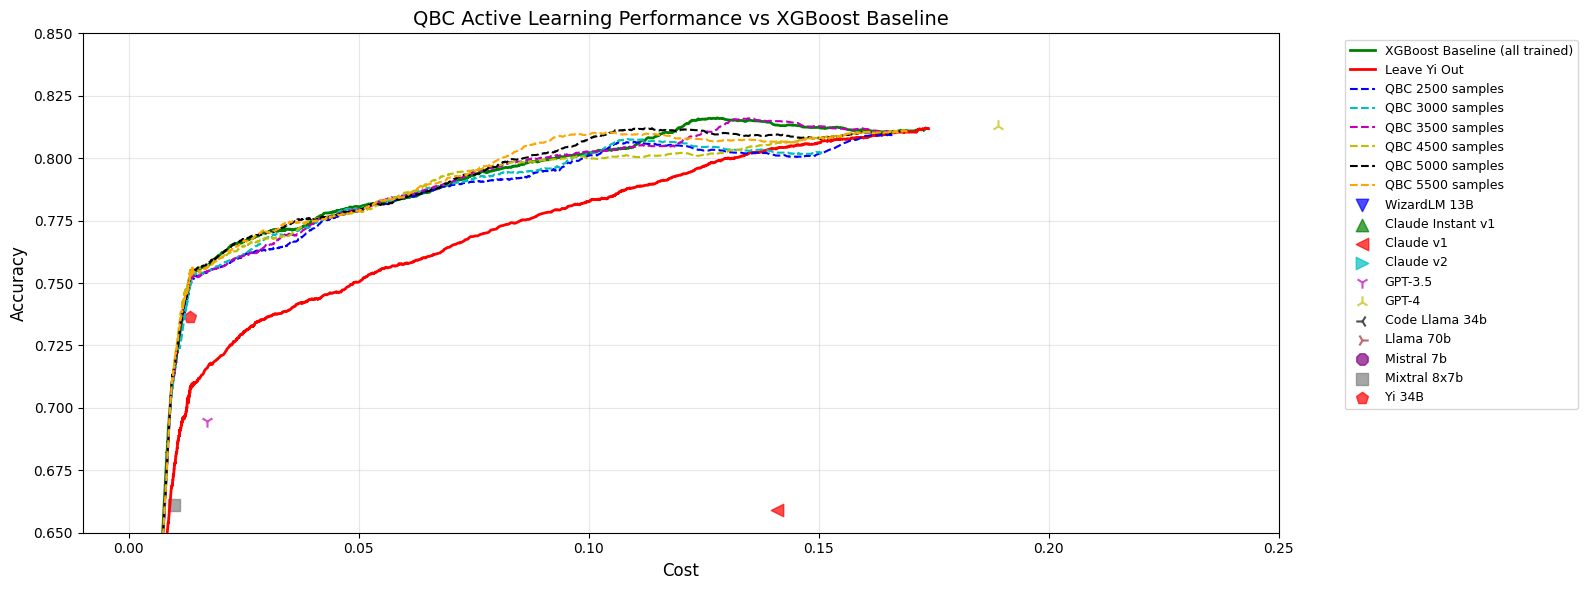

In [12]:
import matplotlib.pyplot as plt
yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')

y_acc_pred_xgb_baseline = xgb_multi.predict(x_test)
acc_xgb_baseline = np.zeros(len(lambdas))
cost_xgb_baseline = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_xgb_baseline[idx], cost_xgb_baseline[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_xgb_baseline, y_cost_test, lam
    )


y_acc_pred_leave_out = np.zeros(y_acc_test.shape)
for idx in range(11):
    if idx != yi_idx:
        y_acc_pred_leave_out[:, idx] = y_acc_pred_xgb_baseline[:, idx]

acc_leave_out = np.zeros(len(lambdas))
cost_leave_out = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_leave_out[idx], cost_leave_out[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_leave_out, y_cost_test, lam
    )


sample_sizes = [2500, 3000, 3500, 4500, 5000, 5500]
qbc_learning_curves = {}
qbc_directory = 'qbc_checkpoints_yi_4'

for n_samples in sample_sizes:
    checkpoint_path = f"{qbc_directory}/Yi_34B_{n_samples}.pkl"
    
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)
        
        if isinstance(checkpoint, dict):
            committee = checkpoint['committee']
        else:
            committee = checkpoint 
        
        predictions = np.zeros((len(x_test), len(committee)))
        for i, model in enumerate(committee):
            predictions[:, i] = model.predict(x_test)
        ensemble_pred = np.mean(predictions, axis=1)
        
        y_acc_pred_qbc = y_acc_pred_leave_out.copy()
        y_acc_pred_qbc[:, yi_idx] = ensemble_pred
        
        acc_curve = np.zeros(len(lambdas))
        cost_curve = np.zeros(len(lambdas))
        
        for idx, lam in enumerate(lambdas):
            acc_curve[idx], cost_curve[idx] = score_auc(
                y_acc_test, y_cost_test, y_acc_pred_qbc, y_cost_test, lam
            )
        
        qbc_learning_curves[n_samples] = (acc_curve, cost_curve)
        
        y_test_yi = y_acc_test[:, yi_idx]
        mse = np.mean((y_test_yi - ensemble_pred) ** 2)

#plot
plt.figure(figsize=(16, 6))

plt.ylim(0.65, 0.85)
plt.xlim(-0.01, 0.25)

plt.plot(cost_xgb_baseline, acc_xgb_baseline, '-', color='green',
         label='XGBoost Baseline (all trained)', linewidth=2)
plt.plot(cost_leave_out, acc_leave_out, '-', color='red',
         label='Leave Yi Out', linewidth=2)

colors_samples = ['b', 'c', 'm', 'y', 'k', 'orange']

for i, n_samples in enumerate(sample_sizes):
    if n_samples in qbc_learning_curves:
        acc_curve, cost_curve = qbc_learning_curves[n_samples]
        plt.plot(cost_curve, acc_curve, '--',
                color=colors_samples[i],
                label=f'QBC {n_samples} samples',
                linewidth=1.5)

markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p']
colors_llms = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'purple', 'gray', 'red']

for idx, llm in enumerate(llms):
    avg_acc = np.mean(y_acc_test[:, idx])
    avg_cost = np.mean(y_cost_test[:, idx]) / np.max(y_cost_test)
    plt.scatter(avg_cost, avg_acc, marker=markers[idx],
                color=colors_llms[idx], s=80, alpha=0.7, label=llms_short[idx])

# Labels and formatting
plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('QBC Active Learning Performance vs XGBoost Baseline', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

In [20]:
from skactiveml.regressor import SklearnRegressor
from skactiveml.pool import QueryByCommittee
from sklearn.ensemble import RandomForestRegressor

def QBC_active_learning_and_save_regressors_rf(x_train, y_train, directory, initial_batch_size=50, batch_size=50, save_interval=1, random_state=42, n_committee=10, n_iterations=150):
    os.makedirs(directory, exist_ok=True)

    yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')
    y_true = y_train[:, yi_idx]
    y_labeled = np.full_like(y_true, np.nan)

    # Initial batch
    np.random.seed(random_state)
    initial_indices = np.random.choice(len(y_true), initial_batch_size, replace=False)
    y_labeled[initial_indices] = y_true[initial_indices]

    # Create committee with diverse Random Forest regressors
    committee = []
    for i in range(n_committee):
      # Vary hyperparameters for diversity
        rf_model = RandomForestRegressor(
          n_estimators=200 + (i * 20), 
          max_depth=10 + (i % 3) * 5, 
          min_samples_split=2 + (i % 3),  
          min_samples_leaf=1 + (i % 2),   
          max_features='sqrt' if i % 2 == 0 else 0.7, 
          bootstrap=True,
          n_jobs=-1,  # Use all CPU cores
          random_state=random_state + i,
        )
        committee.append(SklearnRegressor(rf_model, missing_label=np.nan))

    # Initial training
    labeled_mask = ~np.isnan(y_labeled)
    for i, model in enumerate(committee):
        labeled_indices = np.where(labeled_mask)[0]
        if len(labeled_indices) > 0:
            model.fit(x_train[labeled_indices], y_labeled[labeled_indices])

    # Save initial checkpoint
    checkpoint_path = f"{directory}/Yi_34B_{initial_batch_size}.pkl"
    with open(checkpoint_path, 'wb') as file:
        pickle.dump(committee, file)
    print(f"Initial checkpoint saved: {initial_batch_size} samples")

    # Initialize QBC
    qbc = QueryByCommittee(missing_label=np.nan)

    # Active learning loop
    for iter in range(n_iterations):
        remaining_unlabeled = np.sum(np.isnan(y_labeled))
        if remaining_unlabeled == 0:
            print(f"All samples labeled after {iter} iterations")
            break

        actual_batch_size = min(batch_size, remaining_unlabeled)

      # Query using QBC (variance-based disagreement)
        query_idx, utilities = qbc.query(
          X=x_train,
          y=y_labeled,
          ensemble=committee,
          fit_ensemble=False,
          return_utilities=True,
          batch_size=actual_batch_size
        )

        # Label the queried samples
        y_labeled[query_idx] = y_true[query_idx]

        # Retrain the committee with newly labeled data
        labeled_mask = ~np.isnan(y_labeled)
        for i, model in enumerate(committee):
            labeled_indices = np.where(labeled_mask)[0]
            if len(labeled_indices) > 0:
                model.fit(x_train[labeled_indices], y_labeled[labeled_indices])

        # Save checkpoint
        if (iter + 1) % save_interval == 0:
            n_labeled = initial_batch_size + ((iter + 1) * batch_size)
            checkpoint_path = f"{directory}/Yi_34B_{n_labeled}.pkl"

            with open(checkpoint_path, 'wb') as file:
                pickle.dump(committee, file)

            print(f"Iteration {iter+1}: {n_labeled} samples saved")

    print("QBC active learning completed.")

In [ ]:
QBC_active_learning_and_save_regressors_rf(
  x_train=x_train,
  y_train=y_acc_train,
  directory='qbc_rf_checkpoints_yi_test_2',
  initial_batch_size=50,
  batch_size=50,
  save_interval=1,
  random_state=42,
  n_committee=10,
  n_iterations=150
)

Initial checkpoint saved: 50 samples
Iteration 1: 100 samples saved
Iteration 2: 150 samples saved
Iteration 3: 200 samples saved
Iteration 4: 250 samples saved
Iteration 5: 300 samples saved
Iteration 6: 350 samples saved
Iteration 7: 400 samples saved
Iteration 8: 450 samples saved
Iteration 9: 500 samples saved
Iteration 10: 550 samples saved
Iteration 11: 600 samples saved
Iteration 12: 650 samples saved
Iteration 13: 700 samples saved
Iteration 14: 750 samples saved
Iteration 15: 800 samples saved
Iteration 16: 850 samples saved
Iteration 17: 900 samples saved
Iteration 18: 950 samples saved
Iteration 19: 1000 samples saved
Iteration 20: 1050 samples saved
Iteration 21: 1100 samples saved
Iteration 22: 1150 samples saved
Iteration 23: 1200 samples saved
Iteration 24: 1250 samples saved
Iteration 25: 1300 samples saved
Iteration 26: 1350 samples saved
Iteration 27: 1400 samples saved
Iteration 28: 1450 samples saved
Iteration 29: 1500 samples saved
Iteration 30: 1550 samples saved


RF QBC 2500 samples - MSE: 0.1326
RF QBC 3100 samples - MSE: 0.1277
RF QBC 3300 samples - MSE: 0.1275
RF QBC 3500 samples - MSE: 0.1271
RF QBC 3700 samples - MSE: 0.1270
RF QBC 3900 samples - MSE: 0.1269


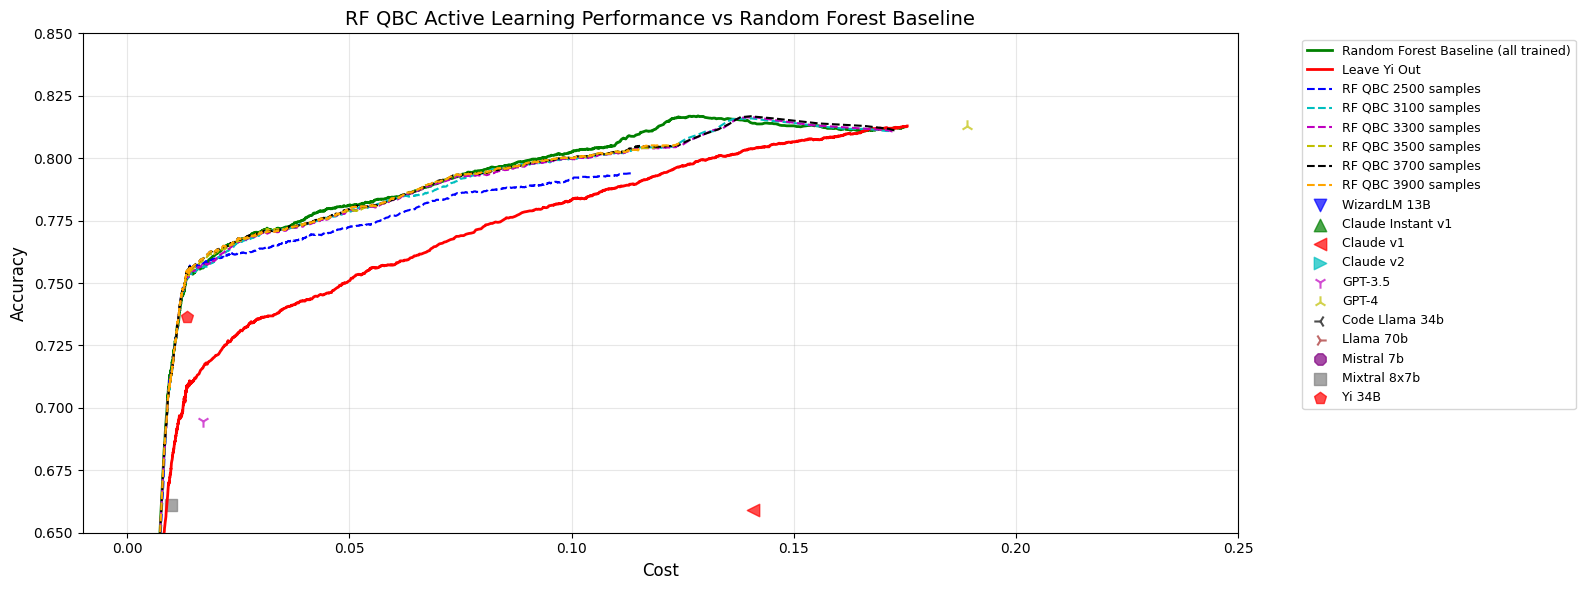

In [11]:
yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')

y_acc_pred_rf_baseline = rf_multi.predict(x_test)
acc_rf_baseline = np.zeros(len(lambdas))
cost_rf_baseline = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_rf_baseline[idx], cost_rf_baseline[idx] = score_auc(
      y_acc_test, y_cost_test, y_acc_pred_rf_baseline, y_cost_test, lam
    )

y_acc_pred_leave_out = np.zeros(y_acc_test.shape)
for idx in range(11):
    if idx != yi_idx:
        y_acc_pred_leave_out[:, idx] = y_acc_pred_rf_baseline[:, idx]

acc_leave_out = np.zeros(len(lambdas))
cost_leave_out = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_leave_out[idx], cost_leave_out[idx] = score_auc(
      y_acc_test, y_cost_test, y_acc_pred_leave_out, y_cost_test, lam
    )
    
sample_sizes = [2500, 3100, 3300, 3500, 3700, 3900]
qbc_learning_curves = {}
qbc_directory = 'qbc_rf_checkpoints_yi_test'

for n_samples in sample_sizes:
    checkpoint_path = f"{qbc_directory}/Yi_34B_{n_samples}.pkl"

    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)

        if isinstance(checkpoint, dict):
            committee = checkpoint['committee']
        else:
            committee = checkpoint

        predictions = np.zeros((len(x_test), len(committee)))
        for i, model in enumerate(committee):
            predictions[:, i] = model.predict(x_test)
        ensemble_pred = np.mean(predictions, axis=1)

        y_acc_pred_qbc = y_acc_pred_leave_out.copy()
        y_acc_pred_qbc[:, yi_idx] = ensemble_pred

        acc_curve = np.zeros(len(lambdas))
        cost_curve = np.zeros(len(lambdas))

        for idx, lam in enumerate(lambdas):
            acc_curve[idx], cost_curve[idx] = score_auc(
              y_acc_test, y_cost_test, y_acc_pred_qbc, y_cost_test, lam
            )

        qbc_learning_curves[n_samples] = (acc_curve, cost_curve)

        y_test_yi = y_acc_test[:, yi_idx]
        mse = np.mean((y_test_yi - ensemble_pred) ** 2)
        print(f"RF QBC {n_samples} samples - MSE: {mse:.4f}")

# Plotting
plt.figure(figsize=(16, 6))

plt.ylim(0.65, 0.85)
plt.xlim(-0.01, 0.25)

plt.plot(cost_rf_baseline, acc_rf_baseline, '-', color='green',
       label='Random Forest Baseline (all trained)', linewidth=2)
plt.plot(cost_leave_out, acc_leave_out, '-', color='red',
       label='Leave Yi Out', linewidth=2)

colors_samples = ['b', 'c', 'm', 'y', 'k', 'orange']

for i, n_samples in enumerate(sample_sizes):
    if n_samples in qbc_learning_curves:
        acc_curve, cost_curve = qbc_learning_curves[n_samples]
        plt.plot(cost_curve, acc_curve, '--',
              color=colors_samples[i],
              label=f'RF QBC {n_samples} samples',
              linewidth=1.5)

markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p']
colors_llms = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'purple', 'gray', 'red']

for idx, llm in enumerate(llms):
    avg_acc = np.mean(y_acc_test[:, idx])
    avg_cost = np.mean(y_cost_test[:, idx]) / np.max(y_cost_test)
    plt.scatter(avg_cost, avg_acc, marker=markers[idx],
              color=colors_llms[idx], s=80, alpha=0.7, label=llms_short[idx])

plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('RF QBC Active Learning Performance vs Random Forest Baseline', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
from skactiveml.pool import CoreSet
from xgboost import XGBRegressor

def CoreSet_active_learning_and_save_regressors(
    x_train,
    y_train,
    directory,
    initial_batch_size=50,
    batch_size=50,
    save_interval=5,
    random_state=42,
    n_iterations=150,
):
    os.makedirs(directory, exist_ok=True)

    yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')
    y_true = y_train[:, yi_idx]
    y_labeled = np.full_like(y_true, np.nan, dtype=float)

    rng = np.random.RandomState(random_state)
    initial_indices = rng.choice(len(y_true), initial_batch_size, replace=False)
    y_labeled[initial_indices] = y_true[initial_indices]

    def make_xgb(seed):
        return XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            device="cuda",
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=seed,
        )

    # initial training
    labeled_indices = np.where(~np.isnan(y_labeled))[0]
    regressor = make_xgb(random_state)
    regressor.fit(x_train[labeled_indices], y_labeled[labeled_indices])

    # save initial checkpoint
    n_labeled = np.sum(~np.isnan(y_labeled))
    checkpoint_path = f"{directory}/Yi_34B_{n_labeled}.pkl"
    with open(checkpoint_path, "wb") as f:
        pickle.dump({"regressor": regressor, "y_labeled": y_labeled}, f)
    print(f"Initial checkpoint saved: {n_labeled} samples")

    coreset = CoreSet(missing_label=np.nan, random_state=random_state)

    # AL loop
    for it in range(n_iterations):
        remaining_unlabeled = np.sum(np.isnan(y_labeled))
        if remaining_unlabeled == 0:
            break

        actual_batch_size = min(batch_size, remaining_unlabeled)

        query_idx, utilities = coreset.query(
            X=x_train,
            y=y_labeled,
            batch_size=actual_batch_size,
            return_utilities=True,
        )

        y_labeled[query_idx] = y_true[query_idx]

        labeled_indices = np.where(~np.isnan(y_labeled))[0]
        regressor = make_xgb(random_state + it + 1)
        regressor.fit(x_train[labeled_indices], y_labeled[labeled_indices])

        if (it + 1) % save_interval == 0:
            n_labeled = np.sum(~np.isnan(y_labeled))
            checkpoint_path = f"{directory}/Yi_34B_{n_labeled}.pkl"
            with open(checkpoint_path, "wb") as f:
                pickle.dump({"regressor": regressor, "y_labeled": y_labeled}, f)
            print(f"Iteration {it+1}: {n_labeled} samples saved")

    print("CoreSet active learning completed.")


In [ ]:
CoreSet_active_learning_and_save_regressors(
  x_train=x_train,
  y_train=y_acc_train,
  directory='coreset_checkpoints_yi',
  initial_batch_size=50,
  batch_size=50,
  save_interval=5,
  random_state=42,
  n_iterations=150
)

In [7]:
yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')

y_acc_pred_xgb_baseline = xgb_multi.predict(x_test)
acc_xgb_baseline = np.zeros(len(lambdas))
cost_xgb_baseline = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_xgb_baseline[idx], cost_xgb_baseline[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_xgb_baseline, y_cost_test, lam
    )

y_acc_pred_leave_out = np.zeros(y_acc_test.shape)
for idx in range(11):
    if idx != yi_idx:
        y_acc_pred_leave_out[:, idx] = y_acc_pred_xgb_baseline[:, idx]

acc_leave_out = np.zeros(len(lambdas))
cost_leave_out = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_leave_out[idx], cost_leave_out[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_leave_out, y_cost_test, lam
    )

sample_sizes = [2600, 3100, 3600, 4100, 4600, 5100]
coreset_learning_curves = {}
coreset_directory = 'coreset_checkpoints_yi'

for n_samples in sample_sizes:
    checkpoint_path = f"{coreset_directory}/Yi_34B_{n_samples}.pkl"

    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)
        regressor = checkpoint["regressor"]

        # CoreSet saves a single regressor, not a committee
        coreset_pred = regressor.predict(x_test)

        y_acc_pred_coreset = y_acc_pred_leave_out.copy()
        y_acc_pred_coreset[:, yi_idx] = coreset_pred

        acc_curve = np.zeros(len(lambdas))
        cost_curve = np.zeros(len(lambdas))

        for idx, lam in enumerate(lambdas):
            acc_curve[idx], cost_curve[idx] = score_auc(
                y_acc_test, y_cost_test, y_acc_pred_coreset, y_cost_test, lam
            )

        coreset_learning_curves[n_samples] = (acc_curve, cost_curve)

        y_test_yi = y_acc_test[:, yi_idx]
        mse = np.mean((y_test_yi - coreset_pred) ** 2)
        print(f"CoreSet {n_samples} samples - MSE: {mse:.4f}")

# Plotting
plt.figure(figsize=(16, 6))

plt.ylim(0.65, 0.85)
plt.xlim(-0.01, 0.25)

plt.plot(cost_xgb_baseline, acc_xgb_baseline, '-', color='green',
       label='XGBoost Baseline (all trained)', linewidth=2)
plt.plot(cost_leave_out, acc_leave_out, '-', color='red',
       label='Leave Yi Out', linewidth=2)

colors_samples = ['b', 'c', 'm', 'y', 'k', 'orange']

for i, n_samples in enumerate(sample_sizes):
    if n_samples in coreset_learning_curves:
        acc_curve, cost_curve = coreset_learning_curves[n_samples]
        plt.plot(cost_curve, acc_curve, '--',
              color=colors_samples[i],
              label=f'CoreSet {n_samples} samples',
              linewidth=1.5)

markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p']
colors_llms = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'purple', 'gray', 'red']

for idx, llm in enumerate(llms):
    avg_acc = np.mean(y_acc_test[:, idx])
    avg_cost = np.mean(y_cost_test[:, idx]) / np.max(y_cost_test)
    plt.scatter(avg_cost, avg_acc, marker=markers[idx],
              color=colors_llms[idx], s=80, alpha=0.7, label=llms_short[idx])

plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('CoreSet Active Learning Performance vs XGBoost Baseline', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

NameError: name 'xgb_multi' is not defined

In [7]:
import re
import time

from skactiveml.regressor import NICKernelRegressor
from skactiveml.pool import ExpectedModelVarianceReduction, SubSamplingWrapper


def _find_latest_yi_checkpoint(directory: str):
    """
    Returns (path, n_labeled) for the checkpoint with the largest n_labeled,
    where filename matches Yi_34B_{n}.pkl. Returns (None, None) if none found.
    """
    if not os.path.isdir(directory):
        return None, None

    best_n = -1
    best_path = None
    pat = re.compile(r"^Yi_34B_(\d+)\.pkl$")

    for fn in os.listdir(directory):
        m = pat.match(fn)
        if not m:
            continue
        n = int(m.group(1))
        if n > best_n:
            best_n = n
            best_path = os.path.join(directory, fn)

    if best_path is None:
        return None, None
    return best_path, best_n


def EMOV_NICK_active_learning_and_save_regressors(
    x_train,
    y_train,
    directory,
    initial_batch_size=50,
    batch_size=50,
    save_interval=5,
    random_state=42,
    n_iterations=150,
    max_candidates=0.15,
    max_eval=2000,
    gamma=15.0,
    resume=True,          
    resume_path=None,       
    force_refit_on_resume=True, 
):
    os.makedirs(directory, exist_ok=True)
    rng = np.random.RandomState(random_state)

    yi_idx = llms.index("zero-one-ai/Yi-34B-Chat")
    y_true = y_train[:, yi_idx].astype(float)

    missing_label = np.nan

    def make_nick(seed):
        return NICKernelRegressor(
            missing_label=missing_label,
            metric_dict={"gamma": gamma},
            random_state=seed,
        )

    regressor = None
    y_labeled = None

    if resume:
        if resume_path is None:
            resume_path, resume_n = _find_latest_yi_checkpoint(directory)
        else:
            resume_n = None

        if resume_path is not None and os.path.exists(resume_path):
            with open(resume_path, "rb") as f:
                ckpt = pickle.load(f)

            y_labeled = ckpt.get("y_labeled", None)
            regressor = ckpt.get("regressor", None)

            if y_labeled is None:
                raise ValueError(f"Checkpoint {resume_path} missing 'y_labeled'.")

            # Safety: shape match
            if y_labeled.shape[0] != y_true.shape[0]:
                raise ValueError(
                    f"Checkpoint y_labeled has shape {y_labeled.shape}, "
                    f"but y_true has shape {y_true.shape}. "
                    "This usually means x_train/y_train ordering or dataset changed."
                )

            print(f"Resuming from checkpoint: {resume_path} (labeled={np.sum(~np.isnan(y_labeled))})")

            if force_refit_on_resume or regressor is None:
                labeled_mask = ~np.isnan(y_labeled)
                regressor = make_nick(random_state)
                regressor.fit(x_train[labeled_mask], y_labeled[labeled_mask])
        else:
            print("No checkpoint found; starting fresh.")
            resume = False 

    if not resume:
        y_labeled = np.full_like(y_true, missing_label, dtype=float)

        # initial random labels
        initial_indices = rng.choice(len(y_true), initial_batch_size, replace=False)
        y_labeled[initial_indices] = y_true[initial_indices]

        labeled_mask = ~np.isnan(y_labeled)
        regressor = make_nick(random_state)
        regressor.fit(x_train[labeled_mask], y_labeled[labeled_mask])

        # initial checkpoint
        n_labeled = int(labeled_mask.sum())
        checkpoint_path = f"{directory}/Yi_34B_{n_labeled}.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump({"regressor": regressor, "y_labeled": y_labeled}, f)
        print(f"Initial NICKernel-EMOV checkpoint saved: {n_labeled} samples")

    base_emov = ExpectedModelVarianceReduction(
        missing_label=missing_label,
        random_state=random_state,
    )
    qs = SubSamplingWrapper(
        query_strategy=base_emov,
        max_candidates=max_candidates,
        exclude_non_subsample=False,
        missing_label=missing_label,
        random_state=random_state,
    )

    iteration_times = []

    for it in range(n_iterations):
        remaining_unlabeled = int(np.sum(np.isnan(y_labeled)))
        if remaining_unlabeled == 0:
            print(f"All samples labeled after {it} iterations")
            break

        actual_batch_size = min(batch_size, remaining_unlabeled)

        unlabeled_mask = np.isnan(y_labeled)
        X_unl = x_train[unlabeled_mask]

        if X_unl.shape[0] > max_eval:
            eval_idx = rng.choice(X_unl.shape[0], size=max_eval, replace=False)
            X_eval = X_unl[eval_idx]
        else:
            X_eval = X_unl

        t0 = time.time()
        query_idx, utilities = qs.query(
            X=x_train,
            y=y_labeled,
            reg=regressor,
            fit_reg=False,
            batch_size=actual_batch_size,
            return_utilities=True,
            X_eval=X_eval,
        )
        t1 = time.time()

        # label newly queried
        y_labeled[query_idx] = y_true[query_idx]

        # refit on labeled subset (your original pattern)
        labeled_mask = ~np.isnan(y_labeled)
        regressor = make_nick(random_state + it + 1)
        regressor.fit(x_train[labeled_mask], y_labeled[labeled_mask])

        n_labeled = int(labeled_mask.sum())
        query_time = t1 - t0
        iteration_times.append(query_time)

        print(f"Iter {it+1}: query_time={query_time:.2f}s, labeled={n_labeled}")

        if (it + 1) % save_interval == 0:
            checkpoint_path = f"{directory}/Yi_34B_{n_labeled}.pkl"
            with open(checkpoint_path, "wb") as f:
                pickle.dump({"regressor": regressor, "y_labeled": y_labeled}, f)

    print("NICKernel-EMOV active learning completed.")
    return y_labeled, iteration_times

In [ ]:
EMOV_NICK_active_learning_and_save_regressors(
    x_train,
    y_acc_train,
    directory="nickernel_EMOV_checkpoints_yi",
    initial_batch_size=50, 
    batch_size=50,
    save_interval=1,
    random_state=42,
    n_iterations=100,      
    max_candidates=0.15,
    max_eval=2000,
    gamma=15.0,
    resume=True,
)

Resuming from checkpoint: nickernel_EMOV_checkpoints_yi/Yi_34B_4750.pkl (labeled=4750)
Iter 1: query_time=2258.86s, labeled=4800
Iter 2: query_time=2276.89s, labeled=4850
Iter 3: query_time=2288.63s, labeled=4900
Iter 4: query_time=2303.00s, labeled=4950
Iter 5: query_time=2321.78s, labeled=5000
Iter 6: query_time=2333.96s, labeled=5050


NicKernel EMOV 1000 samples - MSE: 0.1464
NicKernel EMOV 1300 samples - MSE: 0.1356
NicKernel EMOV 1600 samples - MSE: 0.1329
NicKernel EMOV 1900 samples - MSE: 0.1322
NicKernel EMOV 2200 samples - MSE: 0.1315
NicKernel EMOV 2500 samples - MSE: 0.1312


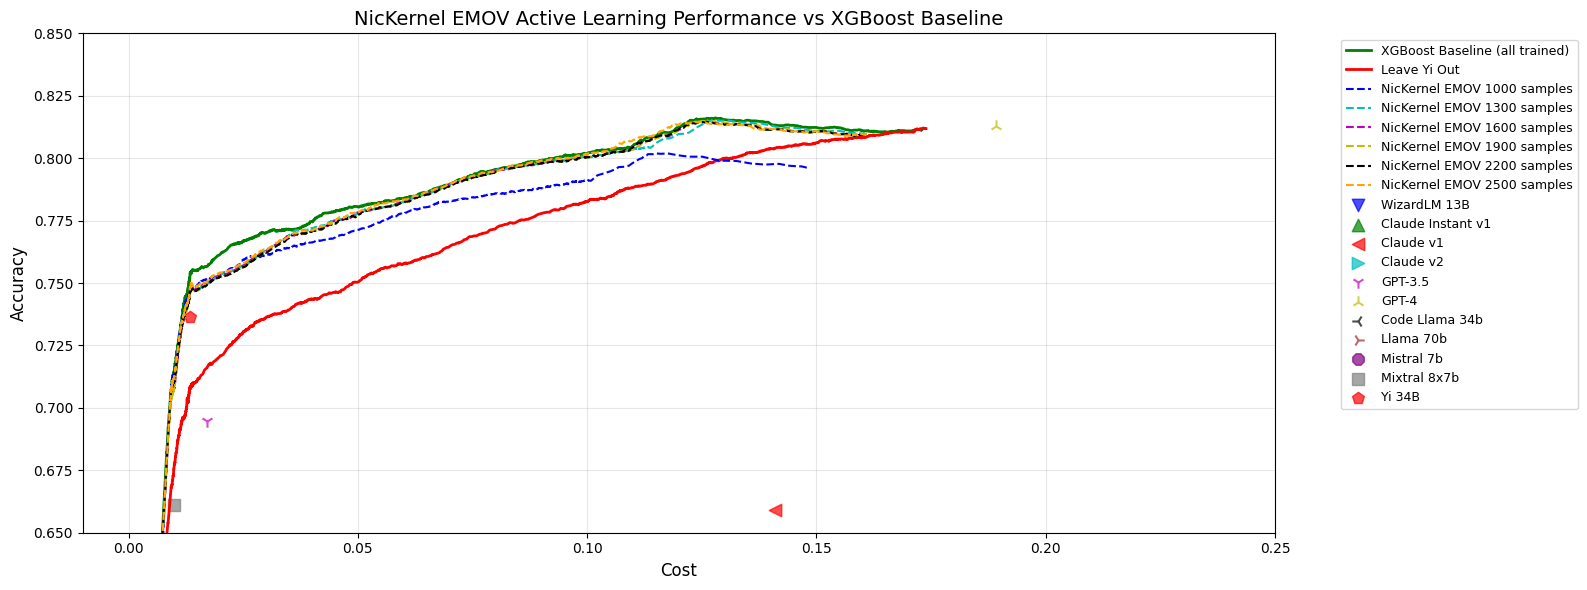

In [14]:
yi_idx = llms.index('zero-one-ai/Yi-34B-Chat')

y_acc_pred_xgb_baseline = xgb_multi.predict(x_test)
acc_xgb_baseline = np.zeros(len(lambdas))
cost_xgb_baseline = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_xgb_baseline[idx], cost_xgb_baseline[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_xgb_baseline, y_cost_test, lam
    )

y_acc_pred_leave_out = np.zeros(y_acc_test.shape)
for idx in range(11):
    if idx != yi_idx:
        y_acc_pred_leave_out[:, idx] = y_acc_pred_xgb_baseline[:, idx]

acc_leave_out = np.zeros(len(lambdas))
cost_leave_out = np.zeros(len(lambdas))

for idx, lam in enumerate(lambdas):
    acc_leave_out[idx], cost_leave_out[idx] = score_auc(
        y_acc_test, y_cost_test, y_acc_pred_leave_out, y_cost_test, lam
    )

sample_sizes = [1000, 1300, 1600, 1900, 2200, 2500]
nickernel_emov_learning_curves = {}
nickernel_emov_directory = 'nickernel_EMOV_checkpoints_yi'

for n_samples in sample_sizes:
    checkpoint_path = f"{nickernel_emov_directory}/Yi_34B_{n_samples}.pkl"

    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)
        regressor = checkpoint["regressor"]

        nickernel_emov_pred = regressor.predict(x_test)

        y_acc_pred_nickernel_emov = y_acc_pred_leave_out.copy()
        y_acc_pred_nickernel_emov[:, yi_idx] = nickernel_emov_pred

        acc_curve = np.zeros(len(lambdas))
        cost_curve = np.zeros(len(lambdas))

        for idx, lam in enumerate(lambdas):
            acc_curve[idx], cost_curve[idx] = score_auc(
                y_acc_test, y_cost_test, y_acc_pred_nickernel_emov, y_cost_test, lam
            )

        nickernel_emov_learning_curves[n_samples] = (acc_curve, cost_curve)

        y_test_yi = y_acc_test[:, yi_idx]
        mse = np.mean((y_test_yi - nickernel_emov_pred) ** 2)
        print(f"NicKernel EMOV {n_samples} samples - MSE: {mse:.4f}")

# Plotting
plt.figure(figsize=(16, 6))

plt.ylim(0.65, 0.85)
plt.xlim(-0.01, 0.25)

plt.plot(cost_xgb_baseline, acc_xgb_baseline, '-', color='green',
     label='XGBoost Baseline (all trained)', linewidth=2)
plt.plot(cost_leave_out, acc_leave_out, '-', color='red',
     label='Leave Yi Out', linewidth=2)

colors_samples = ['b', 'c', 'm', 'y', 'k', 'orange']

for i, n_samples in enumerate(sample_sizes):
    if n_samples in nickernel_emov_learning_curves:
        acc_curve, cost_curve = nickernel_emov_learning_curves[n_samples]
        plt.plot(cost_curve, acc_curve, '--',
            color=colors_samples[i],
            label=f'NicKernel EMOV {n_samples} samples',
            linewidth=1.5)

markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p']
colors_llms = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'purple', 'gray', 'red']

for idx, llm in enumerate(llms):
    avg_acc = np.mean(y_acc_test[:, idx])
    avg_cost = np.mean(y_cost_test[:, idx]) / np.max(y_cost_test)
    plt.scatter(avg_cost, avg_acc, marker=markers[idx],
            color=colors_llms[idx], s=80, alpha=0.7, label=llms_short[idx])

plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('NicKernel EMOV Active Learning Performance vs XGBoost Baseline', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()